# BitCoin Closing Price Prediction

The goal is to predict bitcoin closing prices, based on previously recorded prices.

Although a precise prediction is desirable, predicting general trends is acceptable.

While this is hardly enough for proper algorithmic trading, it serves as a good start.

## Data Source

The data is from coindesk.com.

To update the dataset, cd into data, then execute `./get_current_data.sh`. This does require [jq](https://stedolan.github.io/jq/) - a really cool cli tool for all things json.

In [9]:
import pandas as pd
df = pd.read_csv('../data/all_time_close.csv')
df.columns = ['date', 'price']
df.tail()

,date,price
2765,2018-02-12,8891.2125
2766,2018-02-13,8516.2438
2767,2018-02-14,9477.8400
2768,2018-02-15,10016.4888
2769,2018-02-16,10178.7125


In [10]:
lookback = 15
batch_size = 64
epochs = 200
test_size = 0.2

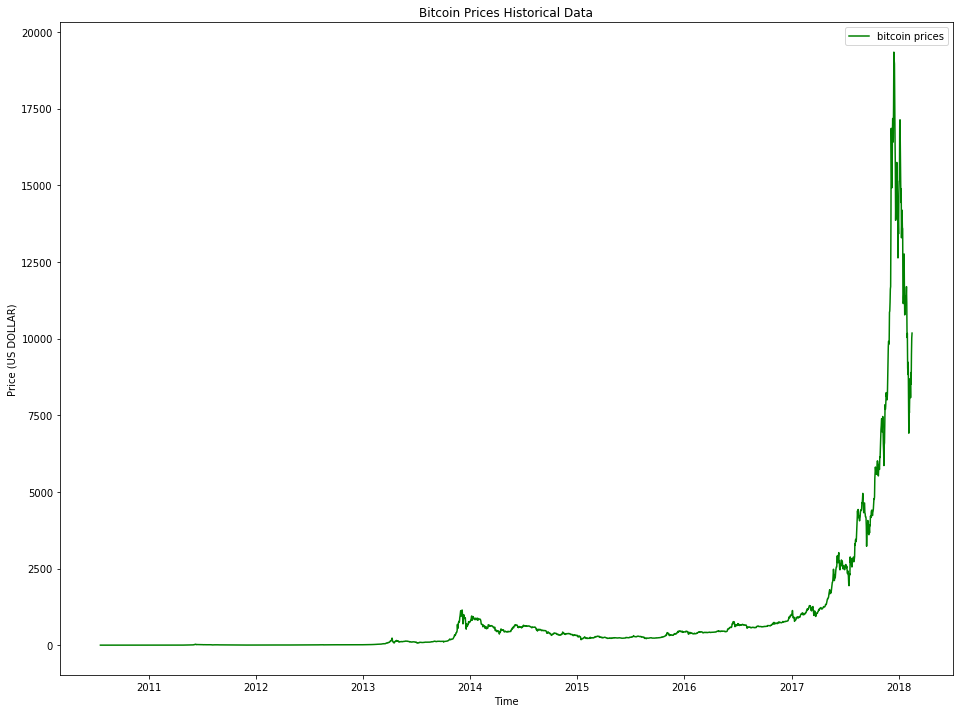

In [11]:
import matplotlib.pyplot as plt
import datetime as dt
# creating timestamps for the x axis
df_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in df.date]

plt.figure(figsize=(16, 12))
plt.plot(df_dates, df.price, color='green', label='bitcoin prices')
plt.title('Bitcoin Prices Historical Data')
plt.ylabel('Price (US DOLLAR)')
plt.xlabel('Time')
plt.legend()
plt.show()

### Feature scaling

Feature scaling is quite important for a lot of ANNs. If we do not scale our features they will easily saturate our first hidden layer from the beginning. When an error gets backpropagated to a saturated neuron it gets blocked from propagating further. Which means that the weights will not really be trained, or much slower, causing the ANN to converge much much slower.

In [12]:
# scaling
import numpy as np
from sklearn.preprocessing import MinMaxScaler
dataset = np.reshape(df.price.values, (-1, 1))
sc = MinMaxScaler(feature_range=(0, 1))
dataset = sc.fit_transform(dataset.astype('float32'))

![prepare labels](img/prepare_x_y.png)

In [13]:
import numpy as np
np.random.seed(42)

X, y = [], []
for i in range(lookback, len(dataset)):
    X.append(dataset[i-lookback:i, 0])
    y.append(dataset[i, 0])

X, y = np.asarray(X), np.asarray(y)

In [14]:
# split into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(2204, 15) (2204,) (551, 15) (551,)


In [15]:
# reshape input into [samples, time_steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [16]:
# truncating, the data must be dividable by batch size
train_truncate = len(X_train) % batch_size
X_train = X_train[train_truncate:]
y_train = y_train[train_truncate:]

test_truncate = len(X_test) % batch_size
X_test = X_test[:len(X_test) - test_truncate]
y_test = y_test[:len(y_test) - test_truncate]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2176, 1, 15) (2176,)
(512, 1, 15) (512,)


## Model: LSTM

Since our data is a time series, recurrent neural networks are a natural fit.
This is due to the chain-like nature of RNNs.

RNNs loop their output back to themselves, which enables them to persist state for a while and learn based on previous learnings.

Something that is great for time series data.

![RNN loop](img/rnn.png)

If we unroll the loop, the chain-like nature becomes more obvious.

![RNN unrolled](img/rnn-unrolled.png)

This chain-like nature shows a strong relationship to sequences and lists. RNNs are an ANN architecture that naturally fits sequences and lists.

### What are LSTMs?

LSTMs are a special kind of RNN (that's why I was talking about RNNs so much previously).

They were introduced by [Hochreiter & Schmidhuber in 1997](http://www.bioinf.jku.at/publications/older/2604.pdf).

LSTMs are specifically designed to tackle a problem called "Long Term Dependency Problem".

#### Long Term Dependency Problem

In theory, RNNs should be capable to predict, based on recent information. However, they don't seem to be able to learn once the gap between the relevant context and the point where it is needed grows too large.

This problem has been explored in depth by [Hochreiter in 1991](http://people.idsia.ch/~juergen/SeppHochreiter1991ThesisAdvisorSchmidhuber.pdf).

LSTMs do not have this problem, they are capable of learning long term dependencies.

The main difference is that, while other RNNs just have a single layer, LSTMs have four layers, that interact with each other in a very specific way.

Single layer of other RNNs:
![single layer rnn](img/rnn-single-layer.png)

LSTMs with four layers:
![four layer lstm](img/lstm-four-layers.png)

In [17]:
# setting up the model
from keras.preprocessing import sequence
from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model, Sequential

model = Sequential()
model.add(LSTM(10, stateful=False, batch_input_shape=(batch_size, 1, lookback)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mae")
model.summary()

/Users/oem/.pyenv/versions/3.6.3/envs/bitcoin-prediction/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (64, 10)                  1040      
_________________________________________________________________
dense_1 (Dense)              (64, 1)                   11        
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
_________________________________________________________________


In [18]:
# fitting the model to the data
hist = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test))

Train on 2176 samples, validate on 512 samples
Epoch 1/200
2176/2176 [==============================] - 1s 366us/step - loss: 0.0067 - val_loss: 0.0733
Epoch 2/200
2176/2176 [==============================] - 0s 31us/step - loss: 0.0018 - val_loss: 0.0183
Epoch 3/200
2176/2176 [==============================] - 0s 33us/step - loss: 9.3230e-04 - val_loss: 0.0216
Epoch 4/200
2176/2176 [==============================] - 0s 35us/step - loss: 9.1284e-04 - val_loss: 0.0231
Epoch 5/200
2176/2176 [==============================] - 0s 32us/step - loss: 8.5663e-04 - val_loss: 0.0245
Epoch 6/200
2176/2176 [==============================] - 0s 33us/step - loss: 8.9415e-04 - val_loss: 0.0259
Epoch 7/200
2176/2176 [==============================] - 0s 35us/step - loss: 8.7483e-04 - val_loss: 0.0289
Epoch 8/200
2176/2176 [==============================] - 0s 34us/step - loss: 8.0279e-04 - val_loss: 0.0287
Epoch 9/200
2176/2176 [==============================] - 0s 29us/step - loss: 8.0007e-04 - val_l

Epoch 76/200
2176/2176 [==============================] - 0s 33us/step - loss: 5.5474e-04 - val_loss: 0.0395
Epoch 77/200
2176/2176 [==============================] - 0s 35us/step - loss: 5.5210e-04 - val_loss: 0.0390
Epoch 78/200
2176/2176 [==============================] - 0s 34us/step - loss: 5.1470e-04 - val_loss: 0.0392
Epoch 79/200
2176/2176 [==============================] - 0s 29us/step - loss: 5.6278e-04 - val_loss: 0.0410
Epoch 80/200
2176/2176 [==============================] - 0s 31us/step - loss: 4.8463e-04 - val_loss: 0.0398
Epoch 81/200
2176/2176 [==============================] - 0s 31us/step - loss: 5.2670e-04 - val_loss: 0.0400
Epoch 82/200
2176/2176 [==============================] - 0s 31us/step - loss: 5.2121e-04 - val_loss: 0.0395
Epoch 83/200
2176/2176 [==============================] - 0s 32us/step - loss: 4.5118e-04 - val_loss: 0.0402
Epoch 84/200
2176/2176 [==============================] - 0s 29us/step - loss: 4.7188e-04 - val_loss: 0.0372
Epoch 85/200
2176/2

2176/2176 [==============================] - 0s 25us/step - loss: 5.1672e-04 - val_loss: 0.0340
Epoch 151/200
2176/2176 [==============================] - 0s 25us/step - loss: 4.2649e-04 - val_loss: 0.0323
Epoch 152/200
2176/2176 [==============================] - 0s 25us/step - loss: 4.5025e-04 - val_loss: 0.0342
Epoch 153/200
2176/2176 [==============================] - 0s 26us/step - loss: 4.4600e-04 - val_loss: 0.0345
Epoch 154/200
2176/2176 [==============================] - 0s 28us/step - loss: 4.1995e-04 - val_loss: 0.0342
Epoch 155/200
2176/2176 [==============================] - 0s 28us/step - loss: 4.3268e-04 - val_loss: 0.0343
Epoch 156/200
2176/2176 [==============================] - 0s 28us/step - loss: 4.6898e-04 - val_loss: 0.0321
Epoch 157/200
2176/2176 [==============================] - 0s 27us/step - loss: 5.1382e-04 - val_loss: 0.0334
Epoch 158/200
2176/2176 [==============================] - 0s 26us/step - loss: 4.4080e-04 - val_loss: 0.0311
Epoch 159/200
2176/2176 

### Small Refresher: Loss Function

In this case we use mean absolute error as loss function.

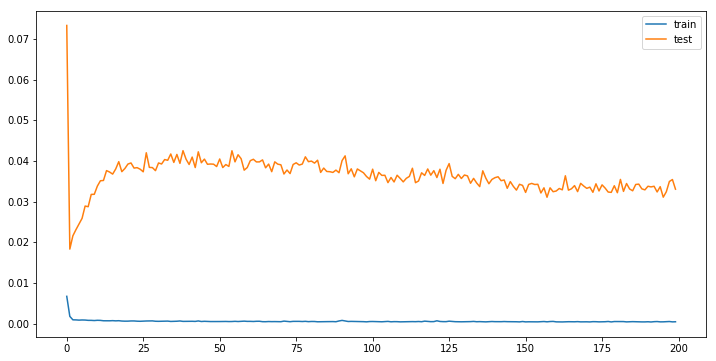

In [19]:
# plotting the loss values for the epochs
plt.figure(figsize=(12,6))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show()

We need to shift around our prediction results to compensate for the truncations before.

We also need to inverse the predictions to "unscale" them again.

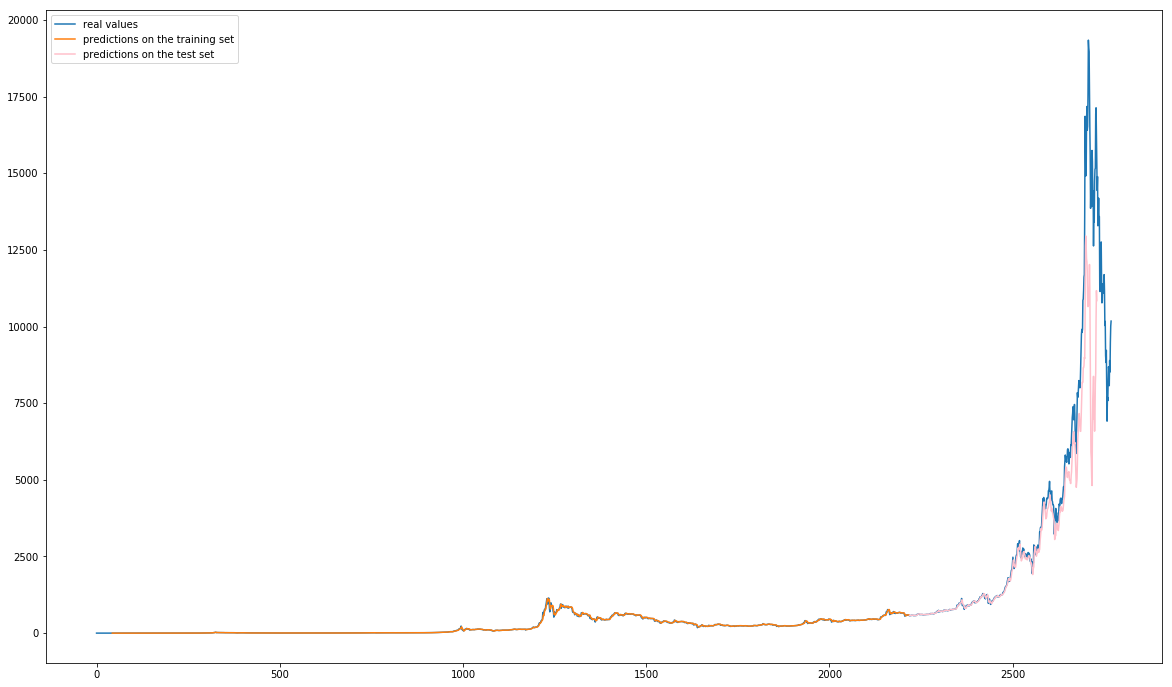

In [20]:
# visualize
predicted_train = model.predict(X_train, batch_size=batch_size)
predicted_test = model.predict(X_test, batch_size=batch_size)

# shift train predictions for plotting
plot_predicted_train = np.empty_like(dataset)
plot_predicted_train[:, :] = np.nan
plot_predicted_train[lookback + train_truncate:len(predicted_train) + lookback + train_truncate, :] = sc.inverse_transform(predicted_train)

# shift test predictions for plotting
plot_predicted_test = np.empty_like(dataset)
plot_predicted_test[:, :] = np.nan
plot_predicted_test[len(predicted_train) + train_truncate + lookback:len(dataset) - test_truncate] = sc.inverse_transform(predicted_test)

plt.figure(figsize=(20,12))

plt.plot(sc.inverse_transform(dataset), label='real values')
plt.plot(plot_predicted_train, label='predictions on the training set')
plt.plot(plot_predicted_test, label='predictions on the test set', color='pink')
plt.legend()
plt.show()

In [21]:
# measure
# RMSE
import math
from sklearn.metrics import mean_squared_error
measure_y_test = np.reshape(y_test, (y_test.shape[0], 1))
rmse = math.sqrt(mean_squared_error(sc.inverse_transform(measure_y_test), sc.inverse_transform(predicted_test)))
print(rmse)

1799.2909019944495
